# Get embeddings to predict low EF and one-year mortality

### Imports

In [1]:
import sys
sys.path.append('../..') 

import os
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, auc

import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.transforms import Compose

import pytorch_lightning as pl
from pytorch_lightning.loggers.neptune import NeptuneLogger
from pytorch_lightning.callbacks import ModelCheckpoint

from ecgxai.network.causalcnn.vae import VAE
from ecgxai.utils.dataset import UniversalECGDataset
from ecgxai.utils.transforms import ApplyGain, ToTensor, To12Lead, Resample
from ecgxai.systems.VAE_system import GaussianVAE
from ecgxai.systems.classification_system import ClassificationSystem
from ecgxai.utils.loss import CombinedLoss, GaussianVAEReconLoss, KLDivergence, BinaryFocalLoss

### Some utils

In [2]:
def get_latents(model, df):
    transform = transforms.Compose([Resample(500), ApplyGain(), ToTensor(), To12Lead()])
    
    dataset = UniversalECGDataset(
        dataset_function="umcu",
        waveform_dir="/raw_data/umcu_median",
        dataset=df,
        transform=transform
    )
    
    dataloader = DataLoader(dataset, batch_size=128, shuffle=False, num_workers=8)
    
    output = trainer.predict(model, dataloaders=dataloader)
    
    embedding = torch.cat([x["mu"] for x in output], dim=0).cpu().numpy()
    waveforms = torch.cat([x["x"] for x in output], dim=0).cpu().numpy()
    reconstructions = torch.cat([x["reconstruction"] for x in output], dim=0).cpu().numpy()
    
    #scaler = StandardScaler()
    #embedding = scaler.fit_transform(embedding)

    latent_rep_df = pd.DataFrame(embedding)
    latent_rep_df.columns = ['latent_' + str(col+1) for col in latent_rep_df.columns]
    latent_dimensions_include = ['latent_' + str(i) for i in [1,5,6,8,9,10,11,12,13,15,16,17,19,22,23,25,26,27,30,31,32]]
    latent_rep_df = latent_rep_df[latent_dimensions_include]
    
    latent_rep_df = pd.concat([df.reset_index(), latent_rep_df], axis=1)
    
    return latent_rep_df, waveforms, reconstructions

In [3]:
def get_prediction(model, df):
    transform = transforms.Compose([Resample(500), ApplyGain(), ToTensor(), To12Lead()])
    
    dataset = UniversalECGDataset(
        dataset_function="umcu",
        waveform_dir="/raw_data/umcu_median",
        dataset=df,
        transform=transform
    )
    
    dataloader = DataLoader(dataset, batch_size=128, shuffle=False, num_workers=8)
    
    output = trainer.predict(model, dataloaders=dataloader)
    
    y = torch.cat([x["label"] for x in output], dim=0).cpu().numpy()
    y_prob = torch.cat([x["y_prob"] for x in output], dim=0).cpu().numpy()

    return y, y_prob

In [4]:
def bootstrap_ci(metric, label, y_prob):
    boot_metric = []
    boot_df = pd.DataFrame({'label': label, 'y_prob': y_prob})

    for i in range(2000):
        boot = boot_df.sample(frac = 1, replace = True).reset_index(drop=True)
        metric_value = metric(boot['label'], boot['y_prob'])
        boot_metric.append(metric_value)

    print('C-stat CI: ' + str(np.quantile(boot_metric,q=0.025,axis=0)) + ' ' + str(np.quantile(boot_metric,q=0.975,axis=0)))

In [5]:
trainer = pl.Trainer(logger=False, gpus=1)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


### Initialize models

In [6]:
vae = GaussianVAE.load_from_checkpoint(checkpoint_path="/training/factorecg/final_vae_epoch_37_2.ckpt")

{'reconstruction_mean', 'mu', 'reconstruction_std', 'std', 'x'}


In [7]:
ef_vencoder = ClassificationSystem.load_from_checkpoint(checkpoint_path="/training/factorecg/ef_vencoder_40.ckpt")

['label', 'y_hat']


In [8]:
mort_vencoder = ClassificationSystem.load_from_checkpoint(checkpoint_path="/training/factorecg/mortality_vencoder.ckpt")

['label', 'y_hat']


## Reduced EF model

### Get data and dataloaders

In [9]:
trainset_path = '/training/secondary_task/train_ef.csv'
df_train = pd.read_csv(trainset_path)
df_train['Gain'] = 0.00488
testset_path = '/training/secondary_task/test_ef.csv'
df_test = pd.read_csv(testset_path)
df_test['Gain'] = 0.00488
df_test = df_test.sort_values('AcquisitionDateTime').groupby('PseudoID').head(1).reset_index(drop=True)

In [10]:
df_train['Label'] = df_train['EF_best_method'] <= 40
df_test['Label'] = df_test['EF_best_method'] <= 40

In [11]:
df_train.to_csv('/training/secondary_task/train_ef_40.csv')
df_test.to_csv('/training/secondary_task/test_ef_40.csv')

### Perform FactorECG-based prediction

In [12]:
latent_rep_df_train, waveforms_train, reconstructions_train = get_latents(vae, df_train)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

The To12Lead transform only works with 8 channel input ECGs, please check.
Above error was caught in dataloader, returning neighbouring sample to continue training
The To12Lead transform only works with 8 channel input ECGs, please check.
Above error was caught in dataloader, returning neighbouring sample to continue training


In [13]:
latent_rep_df_test, waveforms_test, reconstructions_test = get_latents(vae, df_test)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

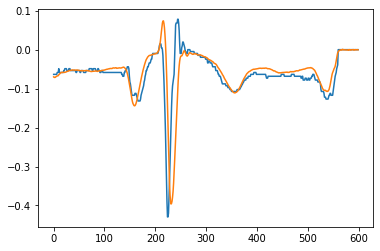

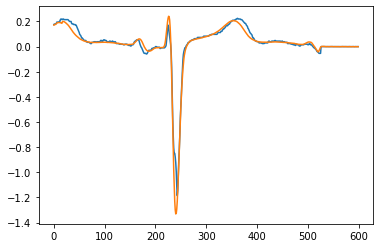

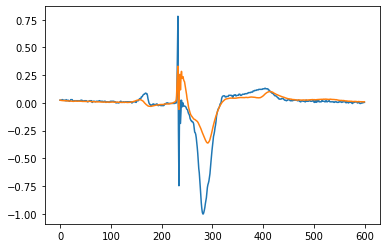

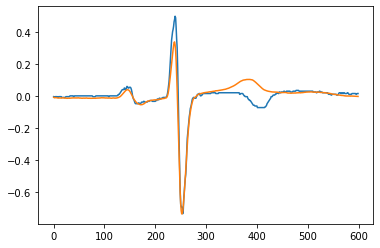

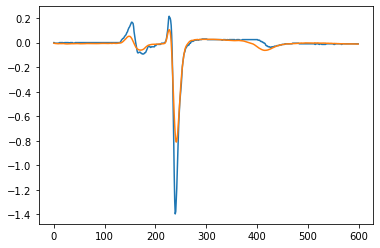

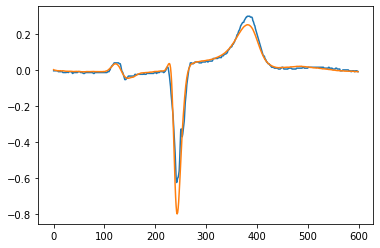

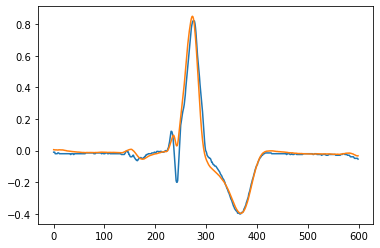

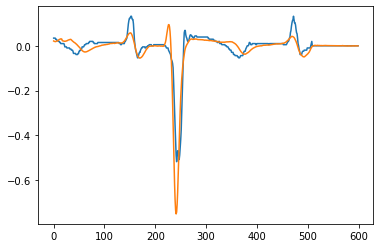

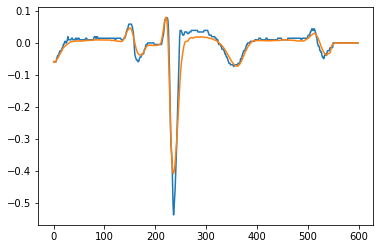

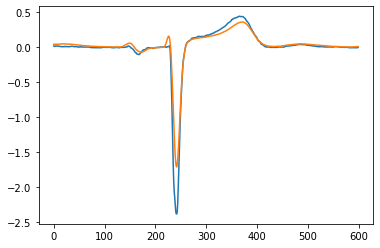

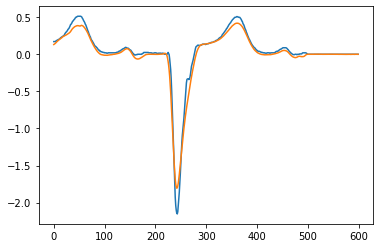

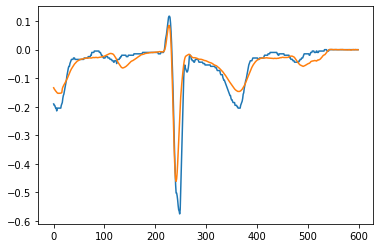

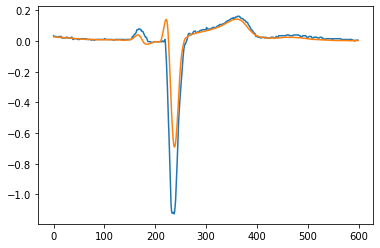

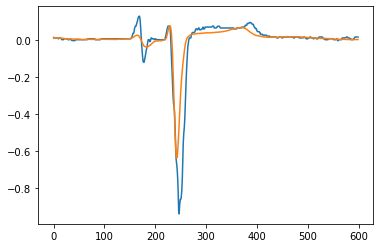

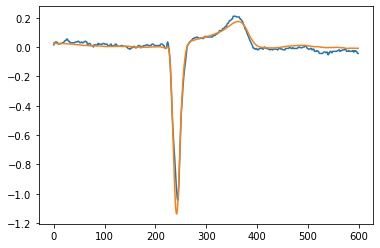

In [14]:
for _ in range(15):
    idx_test = np.random.randint(df_train.shape[0])
    plt.plot(waveforms_train[idx_test,6,:])
    plt.plot(reconstructions_train[idx_test,6,:])
    plt.show()

In [15]:
x_cols = latent_rep_df_train.columns[latent_rep_df_train.columns.str.startswith('latent_')]

In [16]:
x_cols

Index(['latent_1', 'latent_5', 'latent_6', 'latent_8', 'latent_9', 'latent_10',
       'latent_11', 'latent_12', 'latent_13', 'latent_15', 'latent_16',
       'latent_17', 'latent_19', 'latent_22', 'latent_23', 'latent_25',
       'latent_26', 'latent_27', 'latent_30', 'latent_31', 'latent_32'],
      dtype='object')

In [17]:
# filled with best values based on hyperopt
params = {'colsample_bytree': 0.88, 'gamma': 0.21, 'learning_rate': 0.06, 'max_depth': 5, 'min_child_weight': 8.0, 'n_estimators': 260, 'subsample': 0.74}

ef_xgboost = xgb.XGBRegressor(objective = "binary:logistic",
                             #scale_pos_weight=1/0.075073, 
                             **params,
                             eval_metric='logloss'
                        ).fit(latent_rep_df_train[x_cols], df_train['Label'])

In [18]:
latent_rep_df_test['Prob'] = ef_xgboost.predict(latent_rep_df_test[x_cols])

In [19]:
pd.crosstab(latent_rep_df_test['Prob'] > 0.2, df_train['Label'])

Label,False,True
Prob,,
False,3172,926
True,1219,352


In [20]:
print(roc_auc_score(df_test['Label'], latent_rep_df_test['Prob']))
bootstrap_ci(roc_auc_score, df_test['Label'], latent_rep_df_test['Prob'])

0.8894241781340604
C-stat CI: 0.8772661424954669 0.9008777372247756


In [21]:
print(average_precision_score(df_test['Label'], latent_rep_df_test['Prob']))
bootstrap_ci(average_precision_score, df_test['Label'], latent_rep_df_test['Prob'])

0.6629096190972908
C-stat CI: 0.6305438283430667 0.6940583596378074


In [22]:
ef_xgboost.save_model('/training/secondary_task/xgboost_ef.save')

### Perform 'black box'-based prediction

In [23]:
y, y_prob = get_prediction(ef_vencoder, df_test)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

In [24]:
print(roc_auc_score(y, y_prob))
bootstrap_ci(roc_auc_score, y, y_prob.squeeze())

0.906157260739824
C-stat CI: 0.8954855726623766 0.9163456154854548


In [25]:
print(average_precision_score(y, y_prob))
bootstrap_ci(average_precision_score, y, y_prob.squeeze())

0.7088961608679234
C-stat CI: 0.6792007818187509 0.7396276267331521


## Mortality model

### Get data and dataloaders

In [26]:
trainset_path = '/training/secondary_task/train_mortality.csv'
df_train = pd.read_csv(trainset_path)
df_train['Gain'] = 0.00488
testset_path = '/training/secondary_task/test_mortality_single.csv'
df_test = pd.read_csv(testset_path)
df_test['Gain'] = 0.00488
df_test = df_test.sort_values('AcquisitionDateTime').groupby('PseudoID').head(1).reset_index(drop=True)

### Perform age/sex based prediction

In [42]:
# filled with best values based on hyperopt
params = {
    'colsample_bytree': 0.66,
    'gamma': 0.44,
    'learning_rate': 0.18,
    'max_depth': 8,
    'min_child_weight': 7.0,
    'n_estimators': 50,
    'subsample': 0.93
}

mort_xgboost = xgb.XGBRegressor(objective = "binary:logistic",
                         **params,
                         eval_metric='logloss'
                        ).fit(df_train[['Age', 'Gender']], df_train['Label'])

In [43]:
df_test['Prob_AS'] = mort_xgboost.predict(df_test[['Age', 'Gender']])

In [44]:
pd.crosstab(df_test['Prob_AS'] > 0.08, df_test['Label'])

Label,0,1
Prob_AS,,
False,39155,2082
True,26490,3252


In [45]:
print(roc_auc_score(df_test['Label'], df_test['Prob_AS']))
bootstrap_ci(roc_auc_score, df_test['Label'], df_test['Prob_AS'])

0.647798313427746
C-stat CI: 0.6407608599771043 0.6554021053956709


In [46]:
print(average_precision_score(df_test['Label'], df_test['Prob_AS']))
bootstrap_ci(average_precision_score, df_test['Label'], df_test['Prob_AS'])

0.12013478927501976
C-stat CI: 0.11508818685871797 0.12568509610599216


### Perform FactorECG-based prediction

In [27]:
latent_rep_df_train, waveforms_train, reconstructions_train = get_latents(vae, df_train)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

The To12Lead transform only works with 8 channel input ECGs, please check.
Above error was caught in dataloader, returning neighbouring sample to continue training
The To12Lead transform only works with 8 channel input ECGs, please check.
Above error was caught in dataloader, returning neighbouring sample to continue training
The To12Lead transform only works with 8 channel input ECGs, please check.
Above error was caught in dataloader, returning neighbouring sample to continue training
The To12Lead transform only works with 8 channel input ECGs, please check.
Above error was caught in dataloader, returning neighbouring sample to continue training
The To12Lead transform only works with 8 channel input ECGs, please check.
Above error was caught in dataloader, returning neighbouring sample to continue training
The To12Lead transform only works with 8 channel input ECGs, please check.
Above error was caught in dataloader, returning neighbouring sample to continue training
The To12Lead tra

In [28]:
latent_rep_df_train['Gender'] = df_train['Gender']
latent_rep_df_train['Age'] = df_train['Age']

In [29]:
latent_rep_df_test, waveforms_test, reconstructions_test = get_latents(vae, df_test)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

The To12Lead transform only works with 8 channel input ECGs, please check.
Above error was caught in dataloader, returning neighbouring sample to continue training
The To12Lead transform only works with 8 channel input ECGs, please check.
Above error was caught in dataloader, returning neighbouring sample to continue training
The To12Lead transform only works with 8 channel input ECGs, please check.
Above error was caught in dataloader, returning neighbouring sample to continue training
The To12Lead transform only works with 8 channel input ECGs, please check.
Above error was caught in dataloader, returning neighbouring sample to continue training


In [30]:
latent_rep_df_test['Gender'] = df_test['Gender']
latent_rep_df_test['Age'] = df_test['Age']

In [31]:
x_cols = latent_rep_df_train.columns[latent_rep_df_train.columns.str.startswith('latent_')].tolist() + ['Age', 'Gender']

In [32]:
# filled with best values based on hyperopt
params = {
    'colsample_bytree': 0.66,
    'gamma': 0.44,
    'learning_rate': 0.18,
    'max_depth': 8,
    'min_child_weight': 7.0,
    'n_estimators': 50,
    'subsample': 0.93
}

mort_xgboost = xgb.XGBRegressor(objective = "binary:logistic",
                         **params,
                         eval_metric='logloss'
                        ).fit(latent_rep_df_train[x_cols], latent_rep_df_train['Label'])

In [33]:
latent_rep_df_test['Prob'] = mort_xgboost.predict(latent_rep_df_test[x_cols])

In [34]:
pd.crosstab(latent_rep_df_test['Prob'] > 0.08, latent_rep_df_test['Label'])

Label,0,1
Prob,,
False,49894,2017
True,15751,3317


In [35]:
print(roc_auc_score(df_test['Label'], latent_rep_df_test['Prob']))
bootstrap_ci(roc_auc_score, df_test['Label'], latent_rep_df_test['Prob'])

0.7630942563743246
C-stat CI: 0.756466058714179 0.769252746221119


In [36]:
print(average_precision_score(df_test['Label'], latent_rep_df_test['Prob']))
bootstrap_ci(average_precision_score, df_test['Label'], latent_rep_df_test['Prob'])

0.21325298157725914
C-stat CI: 0.2042005518976031 0.22357932281136683


In [37]:
mort_xgboost.save_model('/training/secondary_task/xgboost_mortality.save')

### Perform 'black box'-based prediction

In [38]:
y, y_prob = get_prediction(mort_vencoder, df_test)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

The To12Lead transform only works with 8 channel input ECGs, please check.
Above error was caught in dataloader, returning neighbouring sample to continue training
The To12Lead transform only works with 8 channel input ECGs, please check.
Above error was caught in dataloader, returning neighbouring sample to continue training
The To12Lead transform only works with 8 channel input ECGs, please check.
Above error was caught in dataloader, returning neighbouring sample to continue training
The To12Lead transform only works with 8 channel input ECGs, please check.
Above error was caught in dataloader, returning neighbouring sample to continue training


In [39]:
print(roc_auc_score(y, y_prob))
bootstrap_ci(roc_auc_score, y, y_prob.squeeze())

0.7506415437173628
C-stat CI: 0.7443623460004999 0.7572009336697407


In [40]:
print(average_precision_score(y, y_prob))
bootstrap_ci(average_precision_score, y, y_prob.squeeze())

0.20804906608577498
C-stat CI: 0.19898104798618582 0.21778075748195366
